In [1]:
import pandas as pd
import joblib
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
# Reading the RFM scaled data from the CSV
rfm_scaled_df = pd.read_csv('rfm_scaled_online_retail_data.csv')

# Preview the dataframe
rfm_scaled_df.head()

,recency,frequency,monetary,CustomerID
0,2.334574,-0.425097,8.363010,12346.0
1,-0.905340,0.354417,0.251699,12347.0
2,-0.175360,-0.035340,-0.027988,12348.0
3,-0.735345,-0.425097,-0.032406,12349.0
4,2.174578,-0.425097,-0.190812,12350.0


In [3]:
# Load saved scaler
scaler = joblib.load('scaler.pkl')


In [4]:
# Define features
features = ['recency', 'frequency', 'monetary']

In [5]:
# Create list to store inertia values and create for loop for k-means algo
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled_df[features])
    inertia.append(kmeans.inertia_)

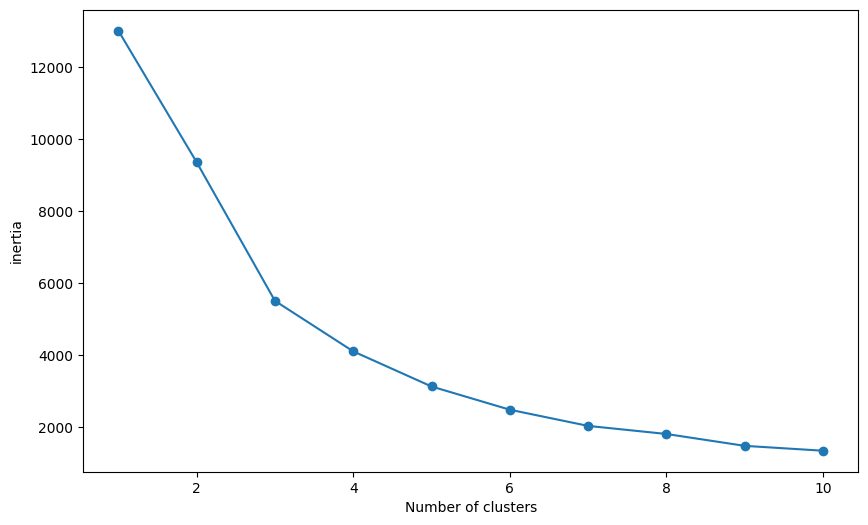

In [6]:
# Plot elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('inertia')
plt.show()

In [7]:
# Apply k-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_scaled_df['Cluster'] = kmeans.fit_predict(rfm_scaled_df[features])

In [8]:
# Print the cluster data
rfm_scaled_df.head()

,recency,frequency,monetary,CustomerID,Cluster
0,2.334574,-0.425097,8.363010,12346.0,3
1,-0.905340,0.354417,0.251699,12347.0,0
2,-0.175360,-0.035340,-0.027988,12348.0,0
3,-0.735345,-0.425097,-0.032406,12349.0,0
4,2.174578,-0.425097,-0.190812,12350.0,1


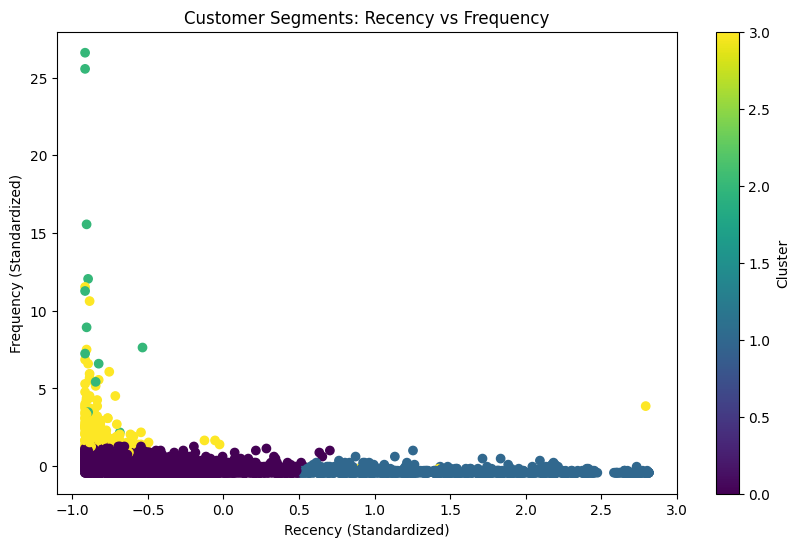

In [9]:
# 2D Plot of Recency vs Frequency
plt.figure(figsize=(10, 6))
plt.scatter(rfm_scaled_df['recency'], rfm_scaled_df['frequency'], 
            c=rfm_scaled_df['Cluster'], cmap='viridis')
plt.title('Customer Segments: Recency vs Frequency')
plt.xlabel('Recency (Standardized)')
plt.ylabel('Frequency (Standardized)')
plt.colorbar(label='Cluster')
plt.show()

In [10]:
# Transform scaled features back to original scale
rfm_original = pd.DataFrame(scaler.inverse_transform(rfm_scaled_df[features]), 
                            columns=['Recency', 'Frequency', 'Monetary'])

In [11]:
# Add cluster labels to original scaled data
rfm_original['Cluster'] = rfm_scaled_df['Cluster']

In [12]:
rfm_original.head()

,Recency,Frequency,Monetary,Cluster
0,325.0,1.0,77183.60,3
1,1.0,7.0,4310.00,0
2,74.0,4.0,1797.24,0
3,18.0,1.0,1757.55,0
4,309.0,1.0,334.40,1


In [13]:
# Calculate original scale cluster profiles
cluster_profiles_original = rfm_original.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

print(cluster_profiles_original)

   Cluster     Recency  Frequency       Monetary
0        0   42.702685   3.682711    1353.625312
1        1  247.075914   1.552015     478.848773
2        2    6.384615  82.538462  127187.959231
3        3   14.500000  22.333333   12690.500392


In [14]:
# Calculate total number of unique customers
total_customers = rfm_scaled_df['CustomerID'].nunique()
print(f"\nTotal Unique Customers: {total_customers}")


Total Unique Customers: 4338


In [15]:
# Calculate the number of customers in each cluster
cluster_counts = rfm_scaled_df.groupby('Cluster')['CustomerID'].nunique().reset_index()
cluster_counts.columns = ['Cluster', 'CustomerCount']

In [16]:
# Print out the customer counts per cluster
print(cluster_counts)

   Cluster  CustomerCount
0        0           3054
1        1           1067
2        2             13
3        3            204


In [17]:
# Calculate percentage of customers in each cluster
cluster_counts['Percentage'] = (cluster_counts['CustomerCount'] / total_customers) * 100

In [18]:
# Print percentage of customers in each cluster
print(cluster_counts[['Cluster', 'Percentage']])

   Cluster  Percentage
0        0   70.401107
1        1   24.596588
2        2    0.299677
3        3    4.702628


In [19]:
# Merge rfm_original with rfm_scaled_data to include CustomerID
rfm_original_with_id = rfm_original.copy()
rfm_original_with_id['CustomerID'] = rfm_scaled_df['CustomerID']
rfm_original_with_id['Cluster'] = rfm_scaled_df['Cluster']


rfm_original_with_id.head()



,Recency,Frequency,Monetary,Cluster,CustomerID
0,325.0,1.0,77183.60,3,12346.0
1,1.0,7.0,4310.00,0,12347.0
2,74.0,4.0,1797.24,0,12348.0
3,18.0,1.0,1757.55,0,12349.0
4,309.0,1.0,334.40,1,12350.0


In [20]:
# Create DataFrames for each cluster
cluster_0 = rfm_original_with_id[rfm_original_with_id['Cluster'] == 0].copy()
cluster_1 = rfm_original_with_id[rfm_original_with_id['Cluster'] == 1].copy()
cluster_2 = rfm_original_with_id[rfm_original_with_id['Cluster'] == 2].copy()
cluster_3 = rfm_original_with_id[rfm_original_with_id['Cluster'] == 3].copy()

# Preview
cluster_0.head()

,Recency,Frequency,Monetary,Cluster,CustomerID
1,1.0,7.0,4310.00,0,12347.0
2,74.0,4.0,1797.24,0,12348.0
3,18.0,1.0,1757.55,0,12349.0
5,35.0,8.0,2506.04,0,12352.0
9,22.0,3.0,2811.43,0,12356.0


In [21]:
# Create summary table for the clusters
cluster_summary = pd.DataFrame({
    'Cluster': ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'],
    'Name': ['Recent Moderate Spenders', 'Infrequent Low Spenders', 'Loyal High Spenders', 'Frequent High Spenders'],
    'Recency (days)': ['~43 days', '~247 days', '~6 days', '~15 days'],
    'Frequency': ['~3.68 purchases', '~1.55 purchases', '~82.54 purchases', '~22.33 purchases'],
    'Monetary': ['~$1,353.63', '~$478.85', '~$127,188.00', '~$12,690.50'],
    'Interpretation': [
        'Customers who have made a purchase recently, shop moderately often, and have moderate spending.',
        'Customers who have not made a purchase in a long time, shop infrequently, and spend little.',
        'Customers who are very recent shoppers, shop very frequently, and have exceptionally high spending.',
        'Customers who have made a recent purchase, shop frequently, and have high spending.'
    ]
})

# Display summary table
from IPython.display import display
display(cluster_summary)

,Cluster,Name,Recency (days),Frequency,Monetary,Interpretation
0,Cluster 0,Recent Moderate Spenders,~43 days,~3.68 purchases,"~$1,353.63","Customers who have made a purchase recently, s..."
1,Cluster 1,Infrequent Low Spenders,~247 days,~1.55 purchases,~$478.85,Customers who have not made a purchase in a lo...
2,Cluster 2,Loyal High Spenders,~6 days,~82.54 purchases,"~$127,188.00","Customers who are very recent shoppers, shop v..."
3,Cluster 3,Frequent High Spenders,~15 days,~22.33 purchases,"~$12,690.50","Customers who have made a recent purchase, sho..."


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_squared_error

In [23]:
# Load the cleaned whole dataset
cleaned_df = pd.read_csv('cleaned_online_retail_data.csv')

cleaned_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373


In [24]:
# Calculate Average Purchase Value for each customer
avg_purchase_value = cleaned_df.groupby('CustomerID').agg({
    'TotalPrice': 'mean'  # Average purchase value = Total Price / Number of Transactions
}).rename(columns={'TotalPrice': 'avg_purchase_value'}).reset_index()

In [25]:
import datetime as dt

# Convert InvoiceDate to datetime
cleaned_df['InvoiceDate'] = pd.to_datetime(cleaned_df['InvoiceDate'])

# Get the max date (most recent transaction date) to calculate the time since first purchase
max_date = cleaned_df['InvoiceDate'].max()

# Calculate the time since first purchase for each customer
time_since_first_purchase = cleaned_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (max_date - x.min()).days  # Days since first purchase
}).rename(columns={'InvoiceDate': 'time_since_first_purchase'}).reset_index()

In [26]:
# Calculate the total number of unique products purchased by each customer
unique_products = cleaned_df.groupby('CustomerID')['StockCode'].nunique().reset_index().rename(columns={'StockCode': 'unique_products_purchased'})

In [27]:
# Calculate the average quantity per transaction for each customer
avg_quantity_per_transaction = cleaned_df.groupby('CustomerID').agg({
    'Quantity': 'mean'
}).rename(columns={'Quantity': 'avg_quantity_per_transaction'}).reset_index()

In [28]:
# Calculate the total number of transactions for each customer
total_transactions = cleaned_df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index().rename(columns={'InvoiceNo': 'total_transactions'})

In [29]:
# Merge new features into one DataFrame
additional_features = avg_purchase_value.merge(time_since_first_purchase, on='CustomerID')
additional_features = additional_features.merge(unique_products, on='CustomerID')
additional_features = additional_features.merge(avg_quantity_per_transaction, on='CustomerID')
additional_features = additional_features.merge(total_transactions, on='CustomerID')

# Merge the additional features with rfm data
rfm_augmented = rfm_original_with_id.merge(additional_features, on='CustomerID', how='left')

rfm_augmented.head()

,Recency,Frequency,Monetary,Cluster,CustomerID,avg_purchase_value,time_since_first_purchase,unique_products_purchased,avg_quantity_per_transaction,total_transactions
0,325.0,1.0,77183.60,3,12346.0,77183.600000,325,1,74215.000000,1
1,1.0,7.0,4310.00,0,12347.0,23.681319,366,103,13.505495,7
2,74.0,4.0,1797.24,0,12348.0,57.975484,357,22,75.516129,4
3,18.0,1.0,1757.55,0,12349.0,24.076027,18,73,8.643836,1
4,309.0,1.0,334.40,1,12350.0,19.670588,309,17,11.588235,1


In [30]:
# Cap outliers in the Monetary column (capping at the 95th percentile)
rfm_augmented['Monetary_capped'] = rfm_augmented['Monetary'].clip(upper=rfm_augmented['Monetary'].quantile(0.80))

In [31]:
# Prepare data for training
X = rfm_augmented[['Recency', 'Frequency', 'avg_purchase_value', 'time_since_first_purchase', 
                   'unique_products_purchased', 'avg_quantity_per_transaction', 'total_transactions']]

y_capped = rfm_augmented['Monetary_capped']

In [32]:
y = y_capped

In [33]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
# Build model
model = Sequential()

In [36]:
# Add layers
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))  
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))  

/Users/lorenzodavis/anaconda3/envs/testenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
# Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [38]:
# Train 
history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 1394963.1250 - val_loss: 1286154.2500
Epoch 2/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 1270534.3750 - val_loss: 525771.2500
Epoch 3/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 723649.0625 - val_loss: 349235.4688
Epoch 4/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 375791.1875 - val_loss: 304767.6875
Epoch 5/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - loss: 427520.1250 - val_loss: 276048.2188
Epoch 6/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 300416.8125 - val_loss: 262497.2812
Epoch 7/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 336025.1875 - val_loss: 253899.2812
Epoch 8/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 311531.0938 - val_loss: 248531.5000
Epoch 9/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - loss: 280118.0312 - val_loss: 245112.9219
Epoch 10/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 273791.7500 - val_loss: 243237.8281
Epoch 11/200
87/87 ━━━━━━━

In [39]:
# Evaluate
y_pred = model.predict(X_test_scaled)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step


In [40]:
# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred.flatten()) / y_test)) * 100

print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Absolute Percentage Error (MAPE): 28.17%


In [41]:
# Define a tolerance level (e.g., predictions within 10% of actual value)
tolerance = 0.10  # 10%

# Calculate accuracy: percentage of predictions within the tolerance range
accuracy = np.mean(np.abs((y_test - y_pred.flatten()) / y_test) <= tolerance) * 100

print(f'Accuracy within ±10% tolerance: {accuracy:.2f}%')

Accuracy within ±10% tolerance: 35.48%


In [42]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Assuming y_test and y_pred are already defined

# Calculate R-squared, MSE, RMSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred.flatten()) / y_test)) * 100

# Calculate accuracy based on 10% tolerance
tolerance = 0.20
accuracy = np.mean(np.abs((y_test - y_pred.flatten()) / y_test) <= tolerance) * 100

# Print out all metrics
print(f'Neural Network R-squared: {r2:.2f}')
print(f'Neural Network Mean Squared Error: {mse:.2f}')
print(f'Neural Network Root Mean Squared Error: {rmse:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'Accuracy within ±10% tolerance: {accuracy:.2f}%')

Neural Network R-squared: 0.88
Neural Network Mean Squared Error: 62502.02
Neural Network Root Mean Squared Error: 250.00
Mean Absolute Percentage Error (MAPE): 28.17%
Accuracy within ±10% tolerance: 59.56%


In [43]:
comparison_df = pd.DataFrame({
    'Actual Value': y_test,
    'Predicted Value': y_pred.flatten()  # Flatten the predicted array if needed
})

# Sort DataFrame by actual values or predicted values
comparison_df_sorted = comparison_df.sort_values(by='Actual Value', ascending=False)

print(comparison_df_sorted.head(100))

      Actual Value  Predicted Value
650        2055.05      1989.418457
3205       2055.05      2035.495850
1497       2055.05      2009.259888
4165       2055.05      1985.116455
1406       2055.05      1838.637695
...            ...              ...
1873       2055.05      1826.327148
305        2055.05      1765.382202
2649       2055.05      2095.396240
1104       2055.05      2084.786865
3640       2055.05      1910.398682

[100 rows x 2 columns]


In [44]:
# Check if y_test has unique values
print(y_test.unique())

# Check distribution of values in y_test
print(y_test.value_counts())

[ 131.94   477.79  1054.73  1313.1   1432.    1071.73   383.7    229.33
  982.07   559.87  2055.05  1122.63    93.82  2004.3   2044.87   495.77
 1869.82  1542.08   157.9    285.89   325.75   439.66   415.2    427.64
 1021.58   541.53   344.33   183.44  1980.57  1236.54  1160.07   318.15
  881.29   183.6   1421.61   375.69   302.1    877.44   216.21  2053.02
  596.85  1266.97   468.41   221.27  1791.56   204.5   1025.44  1316.66
 2027.5    388.25   191.95  1095.08   501.03   365.45  1842.14   712.78
  467.51   351.65   185.65   679.45   530.15  1429.64   701.23   301.72
  380.39   287.62   529.73   427.8    349.83   123.1    337.44   478.09
 1551.78   210.31   770.12   567.36  1335.19   343.23   595.42   605.8
 1290.53   213.96   376.72  1998.     714.96   623.5   1674.69  1002.9
  372.7    777.53   333.48   349.1   1116.68   201.16   720.86   743.53
  580.05   519.69  1839.3    345.    1504.27   134.46   797.71   859.71
  422.47  1449.32   138.68   605.06  1353.74  1344.78   242.35   6